In [1]:
# import setGPU
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.utils import shuffle
import h5py
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Anomalous"]

Using TensorFlow backend.


In [3]:

#Choose where to load the files from
b_h5 = '/eos/cms/store/user/fsiroky/hdf5_data/'
# b_h5 = '/mnt/hdf5test/'
# b_h5   = '/home/test_local/'

pds  = {1: 'BTagCSV', 2: 'BTagMu', 3: 'Charmonium', 4:'DisplacedJet', 5: 'DoubleEG',
        6: 'DoubleMuon', 7: 'DoubleMuonLowMass',
       # 8: 'FSQJets', 9: 'HighMultiplicityEOF', #NOT ENOUGH DATA, NOTEBOOK FAILES
        10: 'HTMHT', 11: 'JetHT', 12: 'MET',
       # 13: 'MinimumBias', #NOT ENOUGH DATA
        14: 'MuonEG', 15: 'MuOnia',
       # 16: 'NoBPTX',
        17: 'SingleElectron', 18: 'SingleMuon', 19: 'SinglePhoton', 20: 'Tau', 21: 'ZeroBias'
}

#Choose which PD to load
nbr = 11

bg_files  = [b_h5+pds[nbr]+'_C_background.h5',b_h5+pds[nbr]+'_D_background.h5', b_h5+pds[nbr]+'_E_background.h5',
             b_h5+pds[nbr]+'_F_background.h5', b_h5+pds[nbr]+'_G_background.h5', b_h5+pds[nbr]+'_H_background.h5']

bg_jets   = [pds[nbr]+"_C_background", pds[nbr]+"_D_background", pds[nbr]+"_E_background",
             pds[nbr]+"_F_background", pds[nbr]+"_G_background", pds[nbr]+"_H_background"]

sig_files = [b_h5+pds[nbr]+'_C_signal.h5',b_h5+pds[nbr]+'_D_signal.h5', b_h5+pds[nbr]+'_E_signal.h5',
             b_h5+pds[nbr]+'_F_signal.h5', b_h5+pds[nbr]+'_G_signal.h5', b_h5+pds[nbr]+'_H_signal.h5']

sig_jets  = [pds[nbr]+"_C_signal", pds[nbr]+"_D_signal", pds[nbr]+"_E_signal",
             pds[nbr]+"_F_signal", pds[nbr]+"_G_signal", pds[nbr]+"_H_signal"]

      
def get_jets(bg_files, bg_jets, sig_files, sig_jets):
    good_jets = np.empty([0,2802])
    bad_jets  = np.empty([0,2802])
                   # Control which time intervals files per PD to load
    for i in range(0,len(bg_files)-5):
        try:
            bg_jetfile  = h5py.File(bg_files[i],'r')
            bg_jet      = bg_jetfile[bg_jets[i]][:]
            sig_jetfile = h5py.File(sig_files[i],'r')
            sig_jet     = sig_jetfile[sig_jets[i]][:]

            bad_jets    = np.concatenate((bad_jets, bg_jet), axis=0)
            good_jets = np.concatenate((good_jets, sig_jet), axis=0)
            print( "Number of good lumis: ", len(sig_jet), " Number of bad lumis: ", len(bg_jet)) 

        except OSError:
            print("This Primary Dataset doesn't have ", bg_jets[i])
    return good_jets, bad_jets

In [4]:
#Load good and bad jets
good_jets, bad_jets = get_jets(bg_files, bg_jets, sig_files, sig_jets)

Number of good lumis:  17238  Number of bad lumis:  492


In [5]:
#Assign good jets class label 0
df1 = pd.DataFrame(good_jets)
# cutted_df = df1.iloc[0:25000, :]   #Temporarily to make training faster
# df1 = cutted_df                   #Temporarily to make training faster
df1['class'] = 0

#Assign bad_jets class label  1
df2 = pd.DataFrame(bad_jets)
# cutted_df = df2.iloc[0:, :]    #Temporarily to make training faster
# df2 = cutted_df                   #Temporarily to make training faster
df2['class'] = 1

del(good_jets)
del(bad_jets)
#Concatenate them
frames = [df1,df2]
data   = pd.concat(frames)

#Shuffle them randomly
data = shuffle(data)
data = data.reset_index(drop=True)

#Save labels and delete them from df not to cheat during training
# labels = data['class'].astype(int)
# del data['class']

# Exploration

In [6]:
data.shape
print(data)

               0          1         2         3         4          5  \
0      16.200157  37.695442  5.000006  6.827379  9.237459  13.156547   
1      16.260916  38.896656  5.000001  6.533804  8.609977  12.108483   
2      15.894256  38.105999  5.000005  6.434277  8.378930  11.747040   
3      17.712095  43.879498  5.000011  6.189270  7.898701  11.206224   
4      16.086588  38.451183  5.000023  6.647241  8.856606  12.501733   
5      16.146975  38.919956  5.000001  6.633830  8.810906  12.456439   
6      16.122478  37.893768  5.000051  6.757165  9.078156  12.867722   
7      17.727160  43.293861  5.000006  6.105983  7.708745  10.945434   
8      16.150234  36.995361  5.000051  6.898060  9.392013  13.377227   
9      16.338734  39.573612  5.000034  6.478638  8.493342  11.999865   
10     16.158945  38.641407  5.000005  6.661135  8.870121  12.531129   
11     16.165747  39.204983  5.000010  6.408061  8.330119  11.718386   
12     16.288019  38.688931  5.000032  6.802344  9.168464  13.02

In [7]:
data.isnull().values.any()

False

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


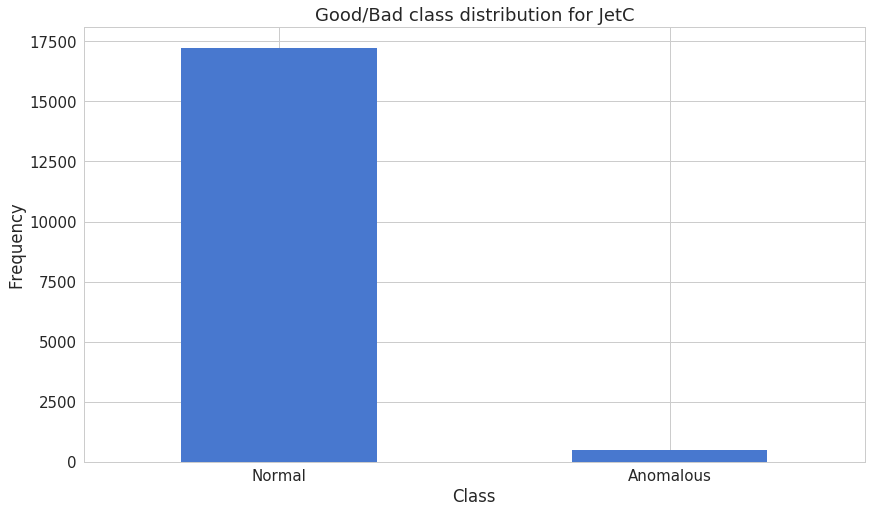

In [9]:
count_classes = pd.value_counts(data['class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Good/Bad class distribution for JetC" )
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
# plt.savefig("jetC_StandardScaler_e350_bs1000_ed14_GOODBAD.pdf")

In [8]:
anomalies = data[data['class'] == 1]
normal    = data[data['class'] == 0]

In [9]:
anomalies.shape
del(anomalies)

In [10]:
normal.shape
del(normal)

Let's have a more graphical representation:

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. 

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$


# Preparing the data


In [11]:
data.shape

(25613, 2803)

In [10]:
from sklearn.preprocessing import StandardScaler

#Normalize the data to make training better
cutted_data = data.iloc[:, 0:2802]
classes     = data.iloc[:, 2802:2803]

# print("Cutted data: ", cutted_data)
# print("Classes : ", classes)
del(data)

np_scaled = StandardScaler().fit_transform(cutted_data)
datas    = pd.DataFrame(np_scaled)
del(np_scaled)
# print("Datas first: ", datas)
datas['class'] = classes
# data = pd.concat([datas, classes])
print("Datas second: ", datas)

# del(np_scaled)
# print(cutted_data)
# print(classes)

Datas second:                 0         1         2         3         4         5         6  \
0      -0.489795 -0.823211 -0.520108  1.148783  1.166395  1.199687 -0.238740   
1      -0.429084 -0.427557 -0.630446  0.065521  0.060137 -0.061159 -0.493962   
2      -0.795458 -0.687983 -0.540170 -0.301723 -0.347201 -0.495984 -0.505930   
3       1.020964  1.213683 -0.409770 -1.205775 -1.193850 -1.146598 -0.664433   
4      -0.603275 -0.574287 -0.159001  0.484093  0.494948  0.411930  0.118043   
5      -0.542936 -0.419883 -0.630446  0.434606  0.414378  0.357440  0.249526   
6      -0.567413 -0.757887  0.432813  0.889701  0.885541  0.852223  0.083616   
7       1.036016  1.020787 -0.520108 -1.513097 -1.528745 -1.460336 -0.217165   
8      -0.539679 -1.053803  0.422782  1.409591  1.438874  1.465170  0.075725   
9      -0.351326 -0.204583  0.071706 -0.138037 -0.145491 -0.191830 -0.105325   
10     -0.530975 -0.511631 -0.540170  0.535361  0.518774  0.447294 -0.212459   
11     -0.524178 -0.32600

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of previously classified lumisections as good. You want to detect any anomaly on new lumisections. We will create this situation by training our model on the normal lumis, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [11]:
X_train, X_test = train_test_split(datas, test_size=0.2, random_state=RANDOM_SEED)
del(datas)
X_train = X_train[X_train['class']== 0]
print(X_train)
X_train = X_train.drop(['class'], axis=1)

y_test = X_test['class']
X_test = X_test.drop(['class'], axis=1)

X_train = X_train.values
X_test = X_test.values

              0         1         2         3         4         5         6  \
12273  1.476666  1.862555  0.262290 -1.296040 -1.242072 -1.188998 -0.076199   
3099   0.691141  0.908520 -0.259309 -1.176610 -1.171407 -1.182677 -0.520140   
14480 -0.558200 -0.702779 -0.349585  0.887317  0.862130  0.811501 -0.295871   
5099  -0.457767 -0.420932 -0.259309  0.460062  0.398516  0.322510 -0.459216   
13480  2.382259  1.680398 -0.490016 -1.586772 -1.507193 -1.224919 -0.528665   
6934  -0.444592 -0.792440  0.151952  1.085604  1.130211  1.155480  1.920139   
8736  -0.587733 -0.215503 -0.108847 -0.427426 -0.476682 -0.566332  1.321234   
12958 -0.572425 -0.660705  0.242229  0.760990  0.765999  0.726064 -0.456835   
16832 -0.455863 -0.850850  0.292382  1.420537  1.446722  1.468282  0.664232   
2798   1.073232  0.732885 -0.580293 -1.559204 -1.531007 -1.420218 -0.396447   
9161  -0.434330 -0.489093 -0.249278  0.802026  0.787465  0.730342 -0.327178   
17489  1.124275  0.901076  0.282352 -1.482771 -1.431

In [12]:
X_train.shape

(13791, 2802)

# Building the model

Our Autoencoder uses 7 fully connected layers with 2000, 1000, 500, 500, 1000, 2000 and 2802  neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [13]:
input_dim = X_train.shape[1]
encoding_dim = 1000

In [14]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [ ]:
nb_epoch = 50
batch_size = 1000

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_nb600_jetCD_bs1000_ec100_3layers.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 13791 samples, validate on 3546 samples
Epoch 1/50
13791/13791 [==============================] - 15s - loss: 44.5740 - acc: 0.0011 - val_loss: 36.1144 - val_acc: 0.0048

In [ ]:
autoencoder = load_model('model_n600_jetCD_bs1000_ec100_3layers.h5')

# Evaluation

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


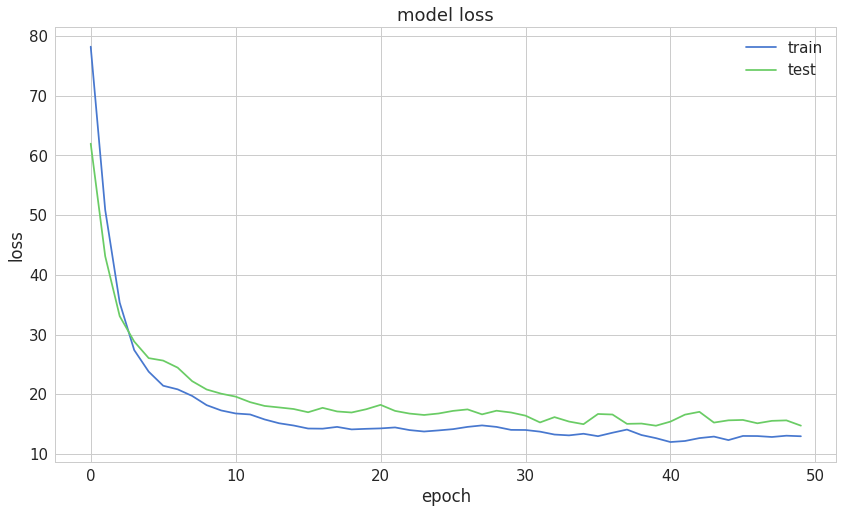

In [44]:
f = plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
f.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_LOSS.pdf")

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [45]:
predictions = autoencoder.predict(X_test)

In [46]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [47]:
error_df.describe()

,reconstruction_error,true_class
count,5123.000000,5123.000000
mean,0.843401,0.026937
std,2.404305,0.161916
min,0.282670,0.000000
25%,0.413953,0.000000
50%,0.531741,0.000000
75%,0.806908,0.000000
max,76.382199,1.000000


## Reconstruction error without anomaly

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


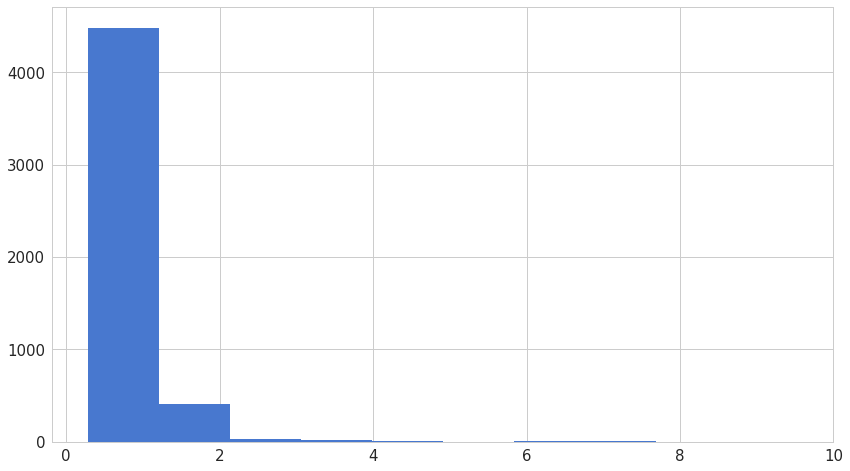

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
fig.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_RECERR.pdf")

## Reconstruction error with anomaly

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


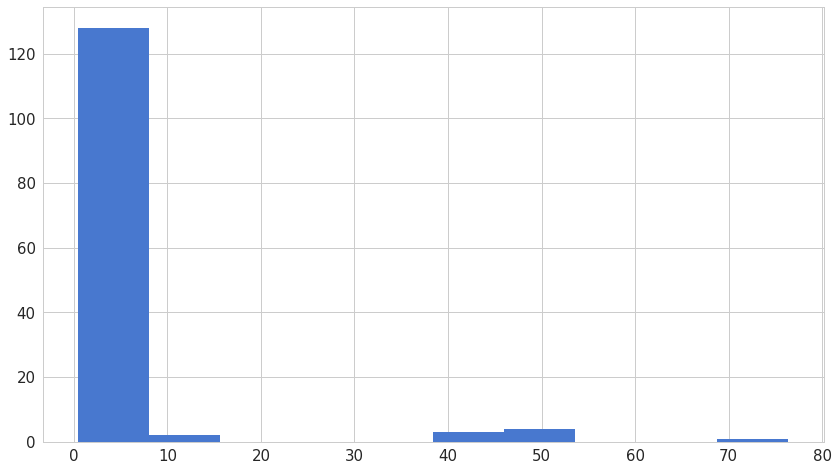

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
fig.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_RECERRFRAUD.pdf")

In [50]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


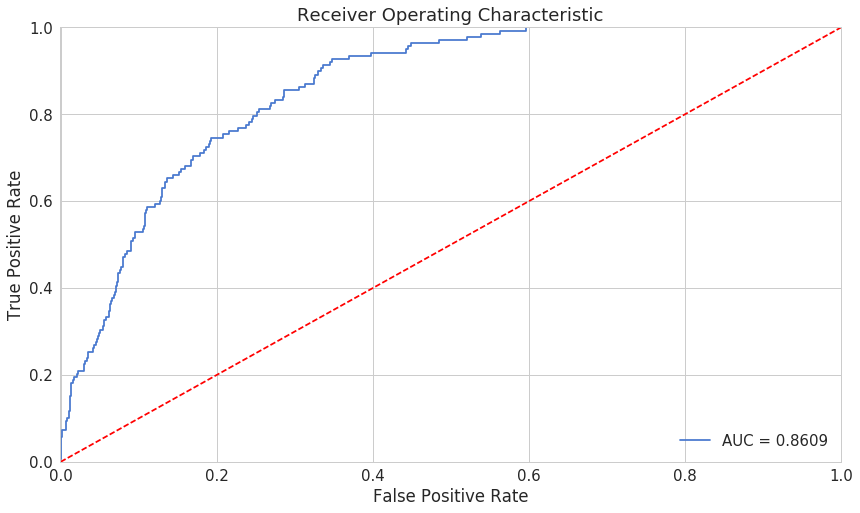

In [51]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_ROC.pdf")

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


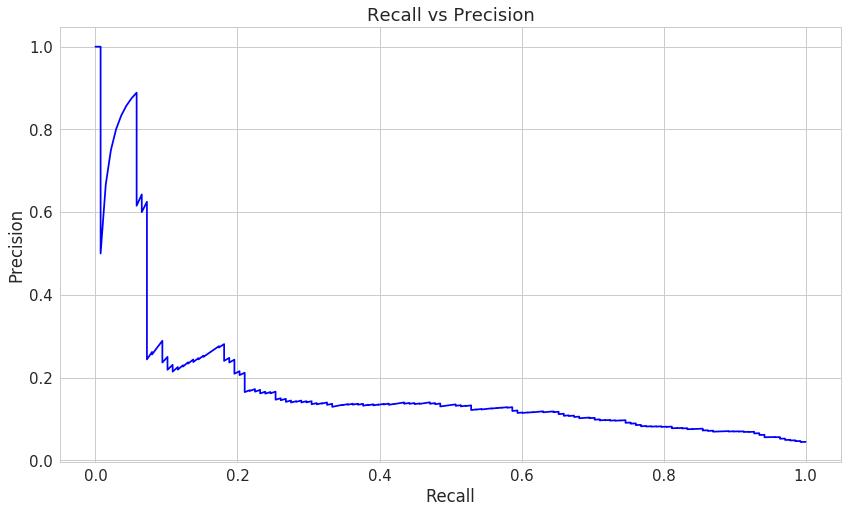

In [52]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14__RECPRE.pdf")

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


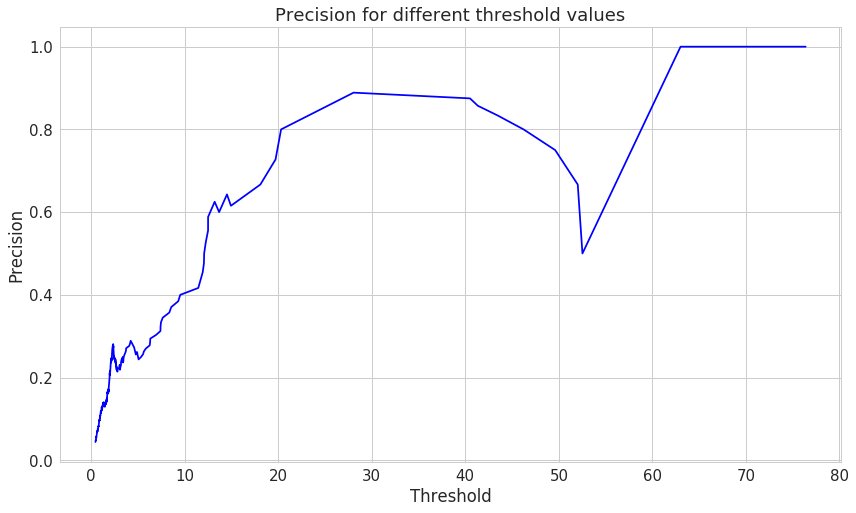

In [53]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()
plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_PRETRE.pdf")

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


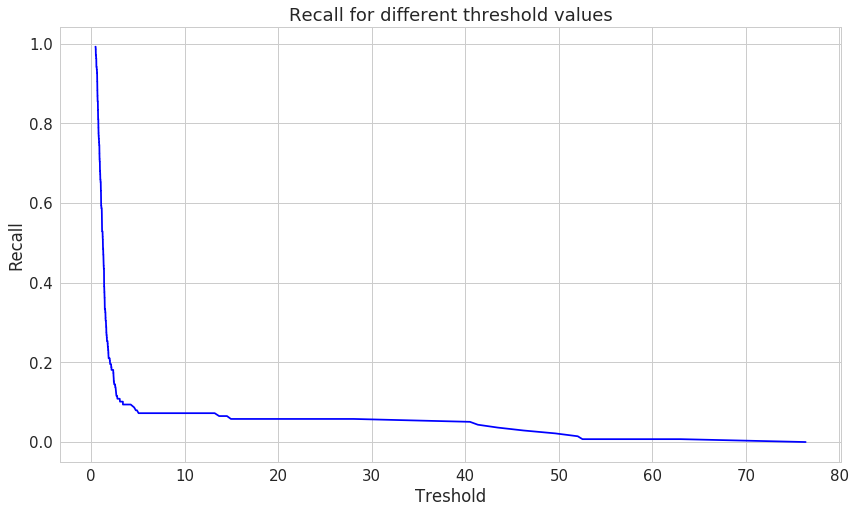

In [54]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Treshold')
plt.ylabel('Recall')
plt.show()
plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_RECTRE.pdf")

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [55]:
threshold = 65

And see how well we're dividing the two types of transactions:

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


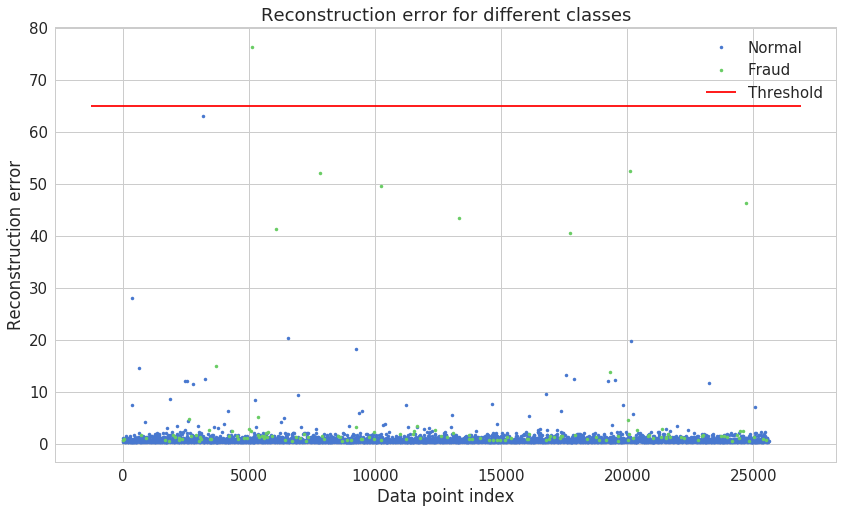

In [56]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()
fig.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_RECON.pdf")

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


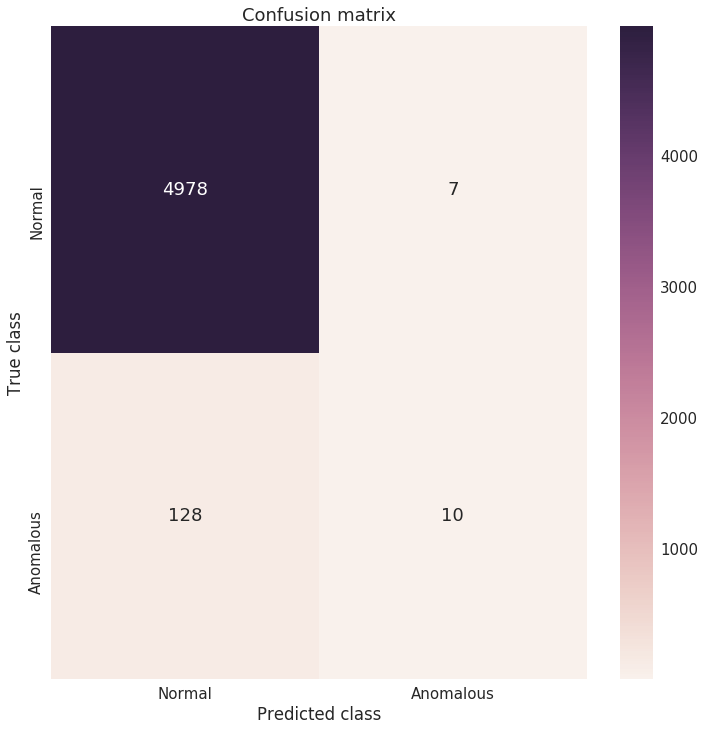

In [38]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_CONFMAX.pdf")

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)